# Fit a quadratic function

Here, we are going to sample a quadratic function of this type
$$
y = a\cdot x^2 + b\cdot x + c
$$
where $a$, $b$ and $c$ are parameters and $x$ is the unique feature.

This example is particularly interesting for our final goal because in the gaussian approximation the $\chi^2$ is a quadratic function of the parameters. Clearly, there are two aspects that are missing w.r.t. a real case scenario:
- usually there is more than one parameter to sample (this is partially covered in the `examples/quadratic_2D`)
- the $\chi^2$ is not exactly a quadratic function. This can be explored only sampling a real world likelihood.

To emulate this function, the main tasks will be:
- generate a dataset
- build and train a simple architecture
- test what the emulator learned.

NOTE: this example contains enough documentation to learn the basics. In case, refer to `*.yaml`files in the main root for additional information about the parameters to use and the possible choices.

### Load libraries and initialise relevant classes

Load libraries: in this example we are first going to generate a dataset (using the DataCollection class), and then build an emulator (using the FFNNEmu class). Here we are calling diectly the architecture we are going to use (instead of the base class Emulator), but it would be equivalent to call Emulator with a string specifying the type of emulator.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from emu_like.datasets import DataCollection
from emu_like.ffnn_emu import FFNNEmu

2025-08-01 20:13:21.884353: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-01 20:13:21.884940: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-01 20:13:21.887896: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-01 20:13:21.896238: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754072001.910792  197749 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754072001.91

In [2]:
data = DataCollection()
emu = FFNNEmu()

### Generate the dataset

In this example we are trying to fit a quadratic relation of the type
$$
y = a\cdot x^2 + b\cdot x + c
$$
as defined in the `quadratic_1D` class in `src/emu_like/datasets.py`.
$x$ is the variable we are going to vary, while $a$, $b$ and $c$ are fixed parameters.

In [3]:
# Features
params = {
  'x': {
      'prior': {
          'min': -80.,
          'max': 80.,
      },
  },
}

# Arguments
y_args = {
  'a': 1./2.,
  'b': -1.,
  'c': 3.
}

Sample dataset

In [4]:
data.sample(
    params=params,
    x_name='grid',
    x_args={'n_samples': 1000},
    y_name='quadratic_1d',
    y_args=y_args,
    verbose=True)

[info] Generating dataset.
[info] Initializing Grid sampler.
----> Number of samples: 1000
[info] Initializing Quadratic1D model.


100%|██████████| 1000/1000 [00:00<00:00, 700802.67it/s]


Train/test split

In [5]:
data = data.get_one_y_dataset()

data.train_test_split(
    frac_train=0.9,
    seed=1567,
    verbose=True)

[info] Splitting dataset in training and testing samples.
----> Fractional number of training samples: 0.9
----> Random seed for train/test split: 1567


Rescale data

In [6]:
data.rescale(
    rescale_x = 'MinMaxScaler',
    rescale_y = 'MinMaxScaler',
    verbose=True)

[info] Rescaling x and y.
----> x with: MinMaxScaler
----> y with: MinMaxScaler
----> Rescaled bounds:
--------> x_train_0 = [0.0, 1.0]
--------> x_test_0 = [0.005010020040080221, 1.001002004008016]
--------> y_train_0 = [0.0, 1.0000000000000002]
--------> y_test_0 = [2.9175842558747805e-05, 0.9803248771609062]


### Build and train the emulator

In [7]:
params = {
    'activation': 'relu',
    'neurons_hidden': [50, 50],
    'batch_normalization': False,
    'dropout_rate': 0.,
    'batch_size': 32,
    'optimizer': 'adam',
    'loss': 'mean_squared_error',
    'want_output_layer': True,
    'data_n_x': data.n_x,
    'data_n_y': data.n_y,
}

In [8]:
emu.build(
    params,
    verbose=True)

[info] Building FFNN architecture
----> Activation function: relu
----> Dropout rate: 0.0
----> Optimizer: adam
----> Loss function: mean_squared_error


2025-08-01 20:13:23.216937: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (32, 50)               │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 50)               │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 1)                │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,701 (10.55 KB)

 Trainable params: 2,701 (10.55 KB)

 Non-trainable params: 0 (0.00 B)

Train

Epoch 1/2000
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1431 - val_loss: 0.0974
Epoch 2/2000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0868 - val_loss: 0.0865
Epoch 3/2000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0795 - val_loss: 0.0786
Epoch 4/2000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0752 - val_loss: 0.0720
Epoch 5/2000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0647 - val_loss: 0.0657
Epoch 6/2000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0652 - val_loss: 0.0582
Epoch 7/2000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0537 - val_loss: 0.0522
Epoch 8/2000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0493 - val_loss: 0.0450
Epoch 9/2000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0388 - val_loss: 0.0371
Epoch 10/2000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0349 - val_loss: 0.0297
Epoch 11/2000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0245 - val_loss: 0.0221
Epoch 12/2000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

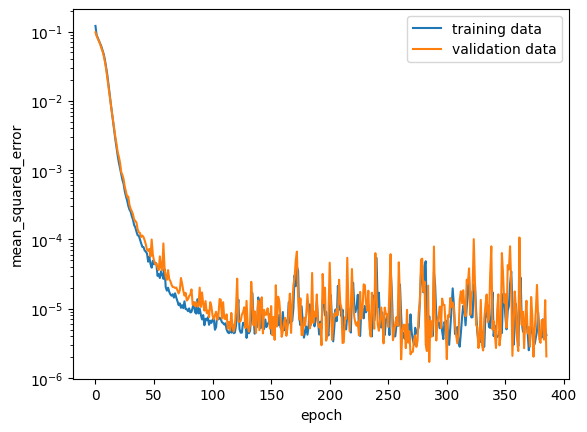

In [9]:
emu.train(
    data,
    epochs=2000,
    learning_rate=1.e-3,
    patience=100,
    path=None,
    get_plots=True,
    verbose=True)

Train again with smaller learning_rate

Epoch 387/2386
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3957e-06 - val_loss: 1.7780e-06
Epoch 388/2386
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0984e-06 - val_loss: 1.9017e-06
Epoch 389/2386
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.1302e-06 - val_loss: 1.9364e-06
Epoch 390/2386
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0967e-06 - val_loss: 1.7962e-06
Epoch 391/2386
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.1464e-06 - val_loss: 1.6796e-06
Epoch 392/2386
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9633e-06 - val_loss: 1.6688e-06
Epoch 393/2386
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.0908e-06 - val_loss: 2.0372e-06
Epoch 394/2386
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2224e-06 - val_loss: 1.5044e-06
Epoch 395/2386
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0477e-06 - val_loss: 1.8450e-06
Epoch 396/2386
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7873e-06 - val_loss: 1.8539e-06
Epoch 397/2386
29/29 ━━━━━━━━━━━━━━━━━━━

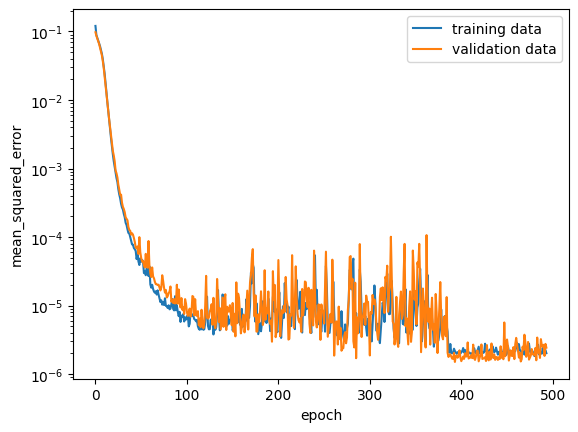

In [10]:
emu.train(
    data,
    epochs=2000,
    learning_rate=1.e-4,
    patience=100,
    path=None,
    get_plots=True,
    verbose=True)

### Testing the result

In [11]:
y_emu = np.array([emu.eval(x) for x in data.x])

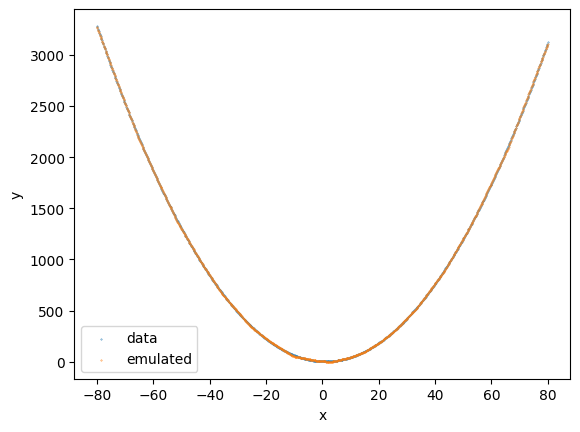

In [12]:
plt.scatter(data.x[:,0], data.y[:,0], s=0.1, label='data')
plt.scatter(data.x[:,0], y_emu[:,0], s=0.1, label='emulated')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

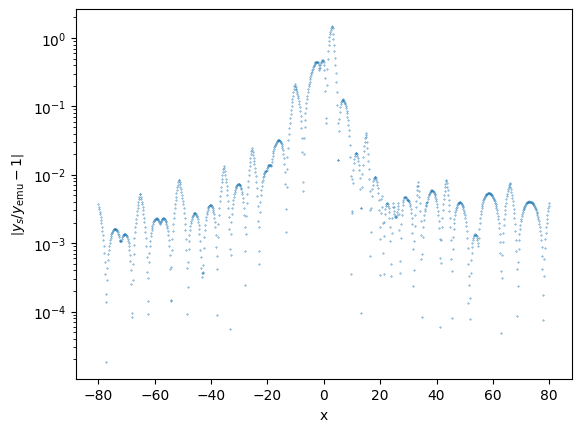

In [13]:
plt.scatter(data.x[:,0], np.abs(y_emu[:,0]/data.y[:,0]-1.), s=0.1)
plt.xlabel('x')
plt.ylabel('$\\left|y_s/y_\\mathrm{emu}-1\\right|$')
plt.yscale('log')